In [13]:
import pandas as pd
import re
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
from torch.utils.data import Dataset
import warnings
warnings.filterwarnings('ignore')


class IntentDataPreprocessor:
    def __init__(self, max_length=64):
        self.max_length = max_length
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def clean_text(self, text):
        """Enhanced text cleaning"""
        text = str(text).lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        text = re.sub(r'@\w+', '@user', text)  # Replace usernames with @user
        text = re.sub(r'#\w+', '', text)  # Remove hashtags
        text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
        text = text.strip()
        return text

    def create_intent_mapping(self, text, inbound):
        """More nuanced intent mapping with confidence scores"""
        text = text.lower()
        confidence = 0.0

        # Define intent patterns with confidence weights
        intent_patterns = {
            'refund_request': (['refund', 'money back'], 0.8),
            'technical_issue': (['crash', 'bug', 'error', 'not working'], 0.7),
            'account_access': (['login', 'password', 'locked', 'cant access'], 0.75),
            'product_inquiry': (['available', 'when', 'stock', 'price'], 0.6),
            'service_complaint': (['poor', 'bad', 'terrible', 'worst'], 0.65),
            'billing_issue': (['charge', 'bill', 'payment', 'charged'], 0.7),
            'general_inquiry': (['how', 'what', 'when', 'where'], 0.5)
        }

        # Find matching intent with highest confidence
        max_confidence = 0
        intent = 'other'

        for intent_name, (keywords, base_confidence) in intent_patterns.items():
            for keyword in keywords:
                if keyword in text:
                    current_confidence = base_confidence
                    # Adjust confidence based on message length and keyword position
                    current_confidence *= min(1.0, len(text.split()) / 10.0)
                    if current_confidence > max_confidence:
                        max_confidence = current_confidence
                        intent = intent_name

        return intent if max_confidence > 0.5 else 'other'

    def preprocess_dataset(self, df, train_size=0.8):
        """Preprocess and split dataset with balanced sampling"""
        # Clean and map intents
        df['clean_text'] = df['text'].apply(self.clean_text)
        df['intent'] = df.apply(lambda x: self.create_intent_mapping(x['clean_text'], x['inbound']), axis=1)

        # Balance dataset
        min_samples = df['intent'].value_counts().min()
        balanced_df = pd.DataFrame()
        for intent in df['intent'].unique():
            intent_data = df[df['intent'] == intent].sample(n=min(min_samples * 2, df[df['intent'] == intent].shape[0]))
            balanced_df = pd.concat([balanced_df, intent_data])

        # Create label mapping
        self.label_map = {label: idx for idx, label in enumerate(balanced_df['intent'].unique())}
        balanced_df['label'] = balanced_df['intent'].map(self.label_map)

        # Split dataset
        train_df, val_df = train_test_split(
            balanced_df,
            train_size=train_size,
            stratify=balanced_df['intent'],
            random_state=42
        )

        return train_df, val_df


In [14]:
class IntentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.encodings = tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors='pt'
        )
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

class IntentClassificationTrainer:
    def __init__(self, num_labels, epochs=3, batch_size=128, learning_rate=2e-5):
    # def __init__(self, num_labels, epochs=3, batch_size=32, learning_rate=2e-5):
        self.model = BertForSequenceClassification.from_pretrained(
            'bert-base-uncased',
            num_labels=num_labels,
            hidden_dropout_prob=0.3,
            attention_probs_dropout_prob=0.3
        )

        self.training_args = TrainingArguments(
            output_dir='./results',
            num_train_epochs=epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            warmup_steps=500,
            weight_decay=0.01,
            learning_rate=learning_rate,
            evaluation_strategy="steps",
            eval_steps=100,
            save_strategy="steps",
            save_steps=100,
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            greater_is_better=True,
            save_total_limit=2,
            gradient_accumulation_steps=2,
            fp16=True,
            logging_steps=50
        )

    def compute_metrics(self, pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
        acc = accuracy_score(labels, preds)
        return {
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    def train(self, train_dataset, eval_dataset):
        trainer = Trainer(
            model=self.model,
            args=self.training_args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            compute_metrics=self.compute_metrics
        )

        trainer.train()
        return trainer.evaluate()



In [15]:
from google.colab import drive
drive.mount("GoogleDrive")

# Load data
large_df = pd.read_csv("GoogleDrive/MyDrive/Datasets/Customer_Support_Dataset/twcs/twcs.csv")
df = large_df.sample(n=200000, random_state=45)

# Initialize preprocessor
preprocessor = IntentDataPreprocessor(max_length=64)

# Preprocess data
train_df, val_df = preprocessor.preprocess_dataset(df)

# Create datasets
train_dataset = IntentDataset(
    train_df['clean_text'].tolist(),
    train_df['label'].tolist(),
    preprocessor.tokenizer,
    preprocessor.max_length
)

val_dataset = IntentDataset(
    val_df['clean_text'].tolist(),
    val_df['label'].tolist(),
    preprocessor.tokenizer,
    preprocessor.max_length
)

# Initialize and train model
trainer = IntentClassificationTrainer(
    num_labels=len(preprocessor.label_map),
    epochs=3,
    batch_size=32,
    learning_rate=1e-5
    # epochs=3,
    # batch_size=16,
    # learning_rate=1e-5
)

# Train and evaluate
results = trainer.train(train_dataset, val_dataset)
print("Final evaluation results:", results)


Drive already mounted at GoogleDrive; to attempt to forcibly remount, call drive.mount("GoogleDrive", force_remount=True).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-1' coro=<Server.serve() done, defined at /usr/local/lib/python3.10/dist-packages/uvicorn/server.py:68> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/uvicorn/main.py", line 579, in run
    server.run()
  File "/usr/local/lib/python3.10/dist-packages/uvicorn/server.py", line 66, in run
    return asyncio.run(self.serve(sockets=sockets))
  File "/usr/local/lib/python3.10/dist-packages/nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
  File "/usr/local/lib/python3.10/dist-packages/nest_asyncio.py", line 92, in run_until_complete

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,1.983900,1.962712,0.151669,0.078166,0.151669,0.065148
200,1.919600,1.886349,0.274759,0.333500,0.274759,0.252178
300,1.714500,1.527589,0.500849,0.477508,0.500849,0.442993
400,1.104100,0.881343,0.707697,0.735250,0.707697,0.657004
500,0.613600,0.540759,0.803905,0.802131,0.803905,0.790280
600,0.366800,0.352179,0.894737,0.893792,0.894737,0.891379


Final evaluation results: {'eval_loss': 0.3521794378757477, 'eval_accuracy': 0.8947368421052632, 'eval_precision': 0.8937915878603648, 'eval_recall': 0.8947368421052632, 'eval_f1': 0.8913785494463365, 'eval_runtime': 3.3253, 'eval_samples_per_second': 1062.776, 'eval_steps_per_second': 33.381, 'epoch': 3.0}


In [5]:

# Save the model
trainer.model.save_pretrained("GoogleDrive/MyDrive/Datasets/BERT_Intent_Classification")

# Save the tokenizer directly from the tokenizer instance
preprocessor.tokenizer.save_pretrained("GoogleDrive/MyDrive/Datasets/BERT_Intent_Classification")

# Save the preprocessed training and validation datasets
train_df.to_csv("GoogleDrive/MyDrive/Datasets/BERT_Intent_Classification/train_data.csv", index=False)
val_df.to_csv("GoogleDrive/MyDrive/Datasets/BERT_Intent_Classification/val_data.csv", index=False)

print("Preprocessed datasets saved successfully.")



# Load the model and tokenizer for inference
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("GoogleDrive/MyDrive/Datasets/BERT_Intent_Classification")
model = BertForSequenceClassification.from_pretrained("GoogleDrive/MyDrive/Datasets/BERT_Intent_Classification")


Preprocessed datasets saved successfully.


In [6]:
# Knowledge base with responses
knowledge_base = {
    "refund_request": "Please provide your order ID, and we'll process your refund.",
    "refund_status": "Your refund request has been received. It may take 5-7 business days to process.",
    "technical_issue": "Can you provide more details about the issue?",
    "app_crash": "We're sorry for the inconvenience. Please reinstall the app or contact support for further assistance.",
    "connectivity_issue": "Please check your internet connection and try again.",
    "password_reset": "Please click on the 'Forgot Password' link to reset your password.",
    "account_locked": "Your account appears to be locked. Please contact customer support to unlock it.",
    "account_details_update": "You can update your account details in the profile section of our app.",
    "product_availability": "This product is currently in stock. Would you like to place an order?",
    "product_not_received": "We're sorry to hear that you haven't received your product. Please provide the order ID for us to assist you.",
    "return_product": "To return a product, please visit the 'Returns' section on our website.",
    "billing_issue": "Could you share more details about the billing issue? We'll resolve it quickly.",
    "invoice_request": "We have emailed your invoice to the registered email address. Please check your inbox.",
    "positive_feedback": "Thank you for your feedback! We're glad to assist you.",
    "negative_feedback": "We're sorry to hear that. Let us help you resolve the issue.",
    "escalate_issue": "We will escalate your concern to our senior team. They will get back to you within 24 hours.",
    "speak_to_agent": "Please hold on. We are connecting you to a live agent."
}

# Map model predictions to knowledge base intents
label_to_intent = {v: k for k, v in preprocessor.label_map.items()}  # Reverse the label_map


def predict_intent(text):
    """
    Predicts the intent of the given text using the BERT model and returns both the intent
    and the confidence score for the prediction.
    """
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)

    # Get the logits (raw prediction scores) from the model
    outputs = model(**inputs)
    logits = outputs.logits

    # Calculate probabilities using softmax
    probabilities = torch.softmax(logits, dim=1).detach().numpy()[0]

    # Get the index of the highest probability (predicted class)
    predicted_index = torch.argmax(logits, dim=1).item()

    # Get the confidence score for the predicted class
    confidence = probabilities[predicted_index]

    # Map the predicted index to the corresponding intent
    predicted_intent = label_to_intent.get(predicted_index, "unknown")

    return predicted_intent, confidence

def inference_engine(text):
    """
    Infers the intent and retrieves the appropriate response from the knowledge base.
    Also includes the confidence score in the response.
    """
    # Predict intent and confidence
    intent, confidence = predict_intent(text)

    # Fetch the response from the knowledge base
    response = knowledge_base.get(intent, "I'm sorry, I didn't understand that.")

    return response, confidence



In [7]:
!pip install fastapi uvicorn nest-asyncio pyngrok transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.2 MB/s eta 0:00:00


In [8]:
!pip install python-multipart

In [9]:
!pip install --upgrade openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.3/390.3 kB 27.9 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.54.5
    Uninstalling openai-1.54.5:
      Successfully uninstalled openai-1.54.5


In [ ]:
#Below is the Final Code

In [39]:
import pandas as pd
import re
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from fastapi.responses import HTMLResponse
from fastapi.middleware.cors import CORSMiddleware
import nest_asyncio
import uvicorn
from pyngrok import ngrok
!ngrok config add-authtoken #add_your_authtoken#
import openai
import os
import warnings
from openai import OpenAI

warnings.filterwarnings('ignore')


# Create a client instance
client = OpenAI(api_key="abcded_your_api")  # Replace with your actual OpenAI API key

# FastAPI setup
app = FastAPI()
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # Allows requests from any origin
    allow_credentials=True,
    allow_methods=["*"],  # Allows all HTTP methods
    allow_headers=["*"],  # Allows all headers
)

# HTML template for chatbot UI
HTML_TEMPLATE = """
<!DOCTYPE html>
<html>
<head>
    <title>Interactive Chatbot</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            background-color: #f4f4f4;
            margin: 0;
            padding: 0;
        }
        .chat-container {
            width: 50%;
            margin: 50px auto;
            background: white;
            padding: 20px;
            border-radius: 8px;
            box-shadow: 0 0 10px rgba(0, 0, 0, 0.1);
        }
        .chat-header {
            text-align: center;
            font-size: 24px;
            font-weight: bold;
            color: #444;
            margin-bottom: 20px;
        }
        .chat-box {
            border: 1px solid #ddd;
            padding: 10px;
            margin-bottom: 10px;
            border-radius: 5px;
            background-color: #f9f9f9;
            height: 300px;
            overflow-y: auto;
        }
        .chat-message {
            margin-bottom: 10px;
        }
        .input-box {
            display: flex;
            margin-top: 20px;
        }
        .input-box input {
            width: 100%;
            padding: 10px;
            border: 1px solid #ddd;
            border-radius: 5px;
        }
        .input-box button {
            padding: 10px;
            background-color: #007bff;
            color: white;
            border: none;
            border-radius: 5px;
            cursor: pointer;
            margin-left: 10px;
        }
        .input-box button:hover {
            background-color: #0056b3;
        }
    </style>
</head>
<body>
    <div class="chat-container">
        <div class="chat-header">Customer Support Chatbot</div>
        <div id="chat-box" class="chat-box"></div>
        <div class="input-box">
            <input id="user-input" type="text" placeholder="Type your message here...">
            <button onclick="sendMessage()">Send</button>
        </div>
    </div>

    <script>
        async function sendMessage() {
            const userInput = document.getElementById('user-input').value;
            const chatBox = document.getElementById('chat-box');

            // Add user's message to the chat
            const userMessage = document.createElement('div');
            userMessage.className = 'chat-message';
            userMessage.textContent = "You: " + userInput;
            chatBox.appendChild(userMessage);

            // Call the FastAPI endpoint
            const response = await fetch('/chat', {
                method: 'POST',
                headers: {
                    'Content-Type': 'application/json',
                },
                body: JSON.stringify({ text: userInput })
            });

            const data = await response.json();

            // Add chatbot's response
            const botMessage = document.createElement('div');
            botMessage.className = 'chat-message';
            botMessage.textContent = "Bot: " + data.response;
            chatBox.appendChild(botMessage);

            // Scroll to the bottom of the chat box
            chatBox.scrollTop = chatBox.scrollHeight;

            // Clear the input field
            document.getElementById('user-input').value = '';
        }
    </script>
</body>
</html>
"""

# Rule-based reasoning for additional processing
def rule_based_reasoning(intent, text):
    rules = {
        "refund_request": lambda: "Please provide your order ID for the refund.",
        "technical_issue": lambda: "Can you describe the issue you're facing?",
        "account_access": lambda: "Is your account locked? Try resetting your password.",
        "general_inquiry": lambda: f"Here's what I found: {text}",
    }
    return rules.get(intent, lambda: "I'm sorry, I didn't understand.")()

#Working Code
def openai_generate_response(prompt):
    try:
        # Use the new ChatCompletion endpoint
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",  # Replace with "gpt-4" if needed
            messages=[
                {"role": "system", "content": "You are a helpful customer service assistant."},
                {"role": "user", "content": prompt},
            ],
            max_tokens=100,
            temperature=0.7,
        )
        # Extract and return the assistant's message
        return response.choices[0].message.content.strip()
    except Exception as e:
        return f"Error generating response: {str(e)}"

# Chat request model
class ChatRequest(BaseModel):
    text: str

@app.get("/", response_class=HTMLResponse)
async def serve_ui():
    return HTML_TEMPLATE

# # Working without confidence score
# @app.post("/chat")
# async def chat(request: ChatRequest):
#     user_message = request.text

#     # Predict intent using the rule-based and ML model
#     intent = "general_inquiry"  # Replace with intent prediction from model
#     response = rule_based_reasoning(intent, user_message)

#     # Enhance response with OpenAI
#     enhanced_response = openai_generate_response(f"User said: {user_message}\nResponse: {response}")

#     return {"response": enhanced_response}

#Working with Confidence score
@app.post("/chat")
async def chat(request: ChatRequest):
    user_message = request.text

    # Predict intent using BERT
    inputs = tokenizer(user_message, return_tensors="pt", truncation=True, padding=True, max_length=128)
    outputs = model(**inputs)
    logits = outputs.logits

    # Calculate probabilities and confidence
    probabilities = torch.softmax(logits, dim=1).detach().numpy()[0]
    predicted_index = torch.argmax(logits, dim=1).item()
    confidence = float(probabilities[predicted_index])  # Convert numpy.float32 to Python float

    # Map the predicted index to an intent
    intent = label_to_intent.get(predicted_index, "unknown")
    response = get_response(intent)

    # Enhance response with OpenAI
    openai_response = openai_generate_response(f"User said: {user_message}\nResponse: {response}")

    # Append the confidence score
    final_response = f"{openai_response}\n\nConfidence: {confidence * 100:.2f}%"

    return {"response": final_response, "confidence": confidence}



# Start the FastAPI app
nest_asyncio.apply()
ngrok_tunnel = ngrok.connect(8000)
print("Public URL:", ngrok_tunnel.public_url)
uvicorn.run(app, host="0.0.0.0", port=8000)


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-190' coro=<Server.serve() done, defined at /usr/local/lib/python3.10/dist-packages/uvicorn/server.py:68> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/uvicorn/main.py", line 579, in run
    server.run()
  File "/usr/local/lib/python3.10/dist-packages/uvicorn/server.py", line 66, in run
    return asyncio.run(self.serve(sockets=sockets))
  File "/usr/local/lib/python3.10/dist-packages/nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
  File "/usr/local/lib/python3.10/dist-packages/nest_asyncio.py", line 92, in run_until_complete
    self._run_once()
  File "/usr/local/lib/python3.10/dist-packages/nest_asyncio.py", line 133, in _run_once
    handle._run()
  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/usr/lib/python3.10/asyncio/tasks.py",

Public URL: https://173a-34-124-132-116.ngrok-free.app


INFO:     Started server process [169]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     192.5.91.79:0 - "GET / HTTP/1.1" 200 OK
INFO:     192.5.91.79:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     192.5.91.79:0 - "POST /chat HTTP/1.1" 200 OK
INFO:     192.5.91.79:0 - "POST /chat HTTP/1.1" 200 OK
INFO:     192.5.91.79:0 - "POST /chat HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [169]


In [ ]:
### ML Model Comparison


ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-1' coro=<Server.serve() done, defined at /usr/local/lib/python3.10/dist-packages/uvicorn/server.py:67> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/uvicorn/main.py", line 579, in run
    server.run()
  File "/usr/local/lib/python3.10/dist-packages/uvicorn/server.py", line 65, in run
    return asyncio.run(self.serve(sockets=sockets))
  File "/usr/local/lib/python3.10/dist-packages/nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
  File "/usr/local/lib/python3.10/dist-packages/nest_asyncio.py", line 92, in run_until_complete
    self._run_once()
  File "/usr/local/lib/python3.10/dist-packages/nest_asyncio.py", line 133, in _run_once
    handle._run()
  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/usr/lib/python3.10/asyncio/tasks.py", l


Training Logistic Regression...
Epoch 1/3 - Train Accuracy: 0.9716, Validation Accuracy: 0.9372, Precision: 0.9424, Recall: 0.9351, F1 Score: 0.9383
Epoch 2/3 - Train Accuracy: 0.9716, Validation Accuracy: 0.9372, Precision: 0.9424, Recall: 0.9351, F1 Score: 0.9383
Epoch 3/3 - Train Accuracy: 0.9716, Validation Accuracy: 0.9372, Precision: 0.9424, Recall: 0.9351, F1 Score: 0.9383

Training Random Forest...
Epoch 1/3 - Train Accuracy: 1.0000, Validation Accuracy: 0.9273, Precision: 0.9332, Recall: 0.9267, F1 Score: 0.9295
Epoch 2/3 - Train Accuracy: 1.0000, Validation Accuracy: 0.9273, Precision: 0.9332, Recall: 0.9267, F1 Score: 0.9295
Epoch 3/3 - Train Accuracy: 1.0000, Validation Accuracy: 0.9273, Precision: 0.9332, Recall: 0.9267, F1 Score: 0.9295

Training Support Vector Machine...
Epoch 1/3 - Train Accuracy: 0.9873, Validation Accuracy: 0.9649, Precision: 0.9680, Recall: 0.9653, F1 Score: 0.9664
Epoch 2/3 - Train Accuracy: 0.9873, Validation Accuracy: 0.9649, Precision: 0.9680, R

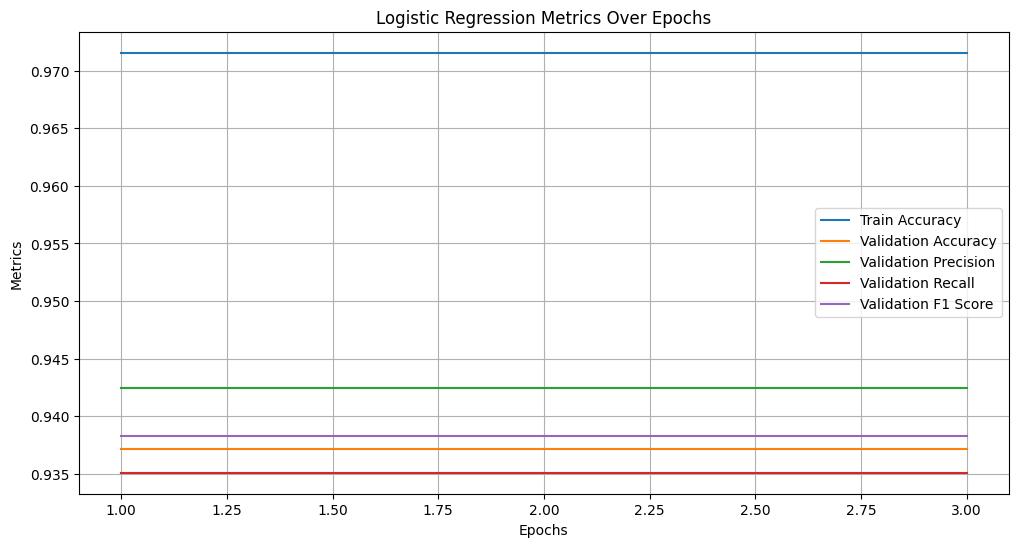

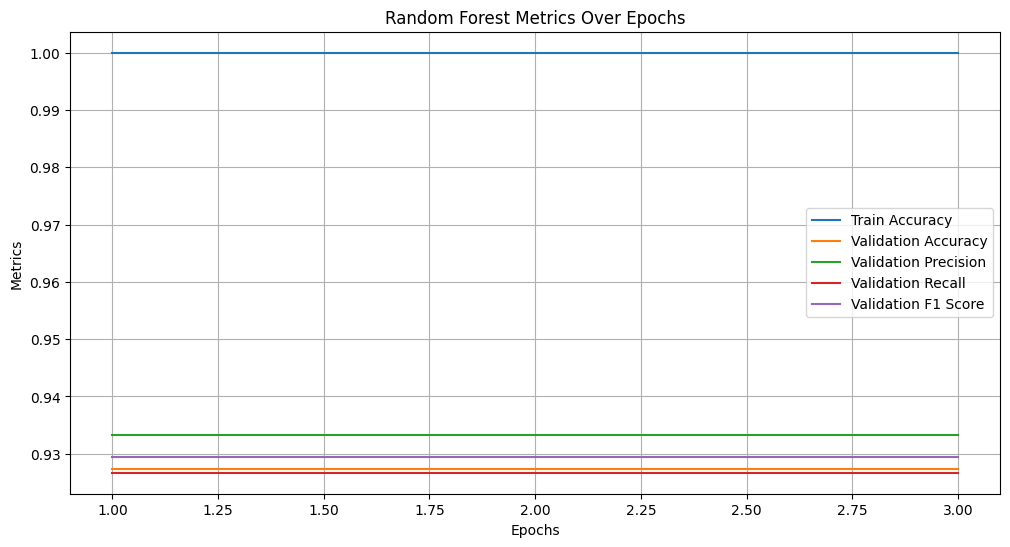

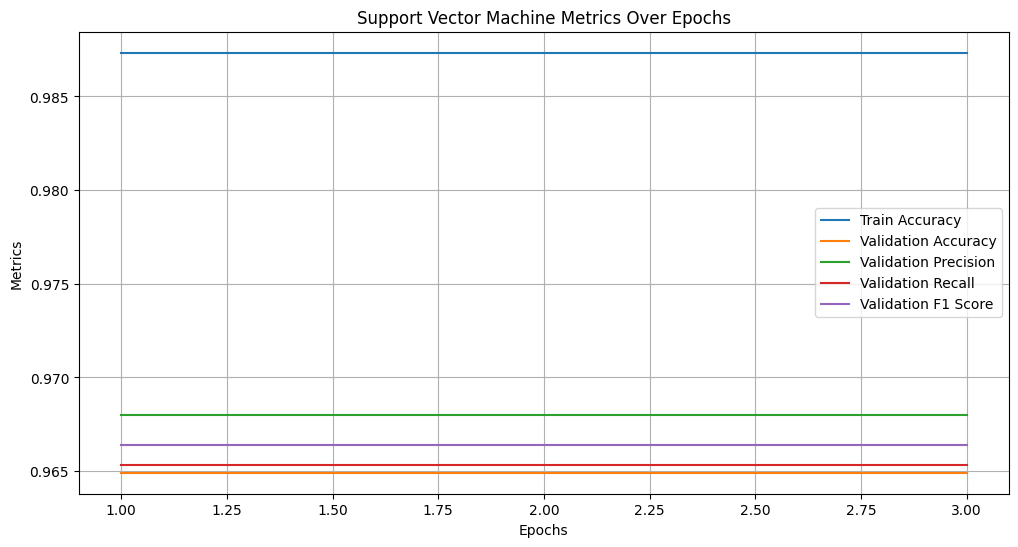


Final Results for Each Model:
                        Final Train Accuracy  Final Validation Accuracy  \
Logistic Regression                 0.971556                   0.937182   
Random Forest                       1.000000                   0.927278   
Support Vector Machine              0.987335                   0.964912   

                        Final Validation Precision  Final Validation Recall  \
Logistic Regression                       0.942410                 0.935097   
Random Forest                             0.933245                 0.926680   
Support Vector Machine                    0.967976                 0.965316   

                        Final Validation F1 Score  
Logistic Regression                      0.938264  
Random Forest                            0.929494  
Support Vector Machine                   0.966405  


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Preprocessing and Feature Extraction for Traditional ML Models
class TraditionalMLPipeline:
    def __init__(self):
        self.vectorizer = TfidfVectorizer(max_features=5000)
        self.label_encoder = LabelEncoder()

    def preprocess(self, train_df, val_df):
        # Transform text data into TF-IDF features
        X_train = self.vectorizer.fit_transform(train_df['clean_text'])
        X_val = self.vectorizer.transform(val_df['clean_text'])

        # Encode labels into integers
        y_train = self.label_encoder.fit_transform(train_df['intent'])
        y_val = self.label_encoder.transform(val_df['intent'])

        return X_train, X_val, y_train, y_val

    def evaluate_model(self, model, X_train, X_val, y_train, y_val, epochs=1):
        metrics_per_epoch = {
            "Train Accuracy": [],
            "Validation Accuracy": [],
            "Validation Precision": [],
            "Validation Recall": [],
            "Validation F1 Score": []
        }

        for epoch in range(1, epochs + 1):
            # Train the model
            model.fit(X_train, y_train)

            # Predictions
            y_pred_train = model.predict(X_train)
            y_pred_val = model.predict(X_val)

            # Metrics
            train_accuracy = accuracy_score(y_train, y_pred_train)
            val_accuracy = accuracy_score(y_val, y_pred_val)

            val_report = classification_report(
                y_val, y_pred_val, target_names=self.label_encoder.classes_, output_dict=True
            )

            metrics_per_epoch["Train Accuracy"].append(train_accuracy)
            metrics_per_epoch["Validation Accuracy"].append(val_accuracy)
            metrics_per_epoch["Validation Precision"].append(val_report["macro avg"]["precision"])
            metrics_per_epoch["Validation Recall"].append(val_report["macro avg"]["recall"])
            metrics_per_epoch["Validation F1 Score"].append(val_report["macro avg"]["f1-score"])

            print(f"Epoch {epoch}/{epochs} - Train Accuracy: {train_accuracy:.4f}, "
                  f"Validation Accuracy: {val_accuracy:.4f}, Precision: {val_report['macro avg']['precision']:.4f}, "
                  f"Recall: {val_report['macro avg']['recall']:.4f}, F1 Score: {val_report['macro avg']['f1-score']:.4f}")

        return metrics_per_epoch


# Initialize the pipeline
traditional_pipeline = TraditionalMLPipeline()

# Prepare data
X_train, X_val, y_train, y_val = traditional_pipeline.preprocess(train_df, val_df)

# Define models to test
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(kernel='linear', probability=True),
}

# Number of epochs for training
epochs = 3

# Train and evaluate each model
results = {}
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    metrics = traditional_pipeline.evaluate_model(model, X_train, X_val, y_train, y_val, epochs=epochs)
    results[model_name] = metrics

# Plot per-epoch metrics
for model_name, model_metrics in results.items():
    plt.figure(figsize=(12, 6))

    # Plot Train Accuracy
    plt.plot(range(1, epochs + 1), model_metrics["Train Accuracy"], label="Train Accuracy")
    # Plot Validation Accuracy
    plt.plot(range(1, epochs + 1), model_metrics["Validation Accuracy"], label="Validation Accuracy")
    # Plot Validation Precision
    plt.plot(range(1, epochs + 1), model_metrics["Validation Precision"], label="Validation Precision")
    # Plot Validation Recall
    plt.plot(range(1, epochs + 1), model_metrics["Validation Recall"], label="Validation Recall")
    # Plot Validation F1 Score
    plt.plot(range(1, epochs + 1), model_metrics["Validation F1 Score"], label="Validation F1 Score")

    plt.title(f"{model_name} Metrics Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.legend()
    plt.grid(True)
    plt.show()

# Display final metrics for each model
final_results = {
    model_name: {
        "Final Train Accuracy": model_metrics["Train Accuracy"][-1],
        "Final Validation Accuracy": model_metrics["Validation Accuracy"][-1],
        "Final Validation Precision": model_metrics["Validation Precision"][-1],
        "Final Validation Recall": model_metrics["Validation Recall"][-1],
        "Final Validation F1 Score": model_metrics["Validation F1 Score"][-1],
    }
    for model_name, model_metrics in results.items()
}

# Convert final metrics to DataFrame
final_results_df = pd.DataFrame.from_dict(final_results, orient='index')
print("\nFinal Results for Each Model:")
print(final_results_df)
